## Wakefield simulation using Wakis

> In this example we will set up and simulate start-to-end an accelerator cavity with a special twist 


In [2]:
import numpy as np                  # arrays and operations
import pyvista as pv                # for 3d plotting
import matplotlib.pyplot as plt     # for 1d, 2d plotting
from tqdm import tqdm

from wakis import GridFIT3D         # grid generation
from wakis import SolverFIT3D       # electromagnetic solver
from wakis import WakeSolver        # wakefield and impedance calculation

pv.global_theme.trame.server_proxy_enabled = True
pv.global_theme.trame.server_proxy_prefix = '/proxy/'
pv.global_theme.window_size = [600, 400]


### Reading and/or generating geometry

Wakis integrates with [**PyVista**](https://docs.pyvista.org/) to import CAD geometries in `.STL`, `.STEP`, or `.OBJ` formats. The mesh is overlaid onto the simulation domain and mapped onto the Cartesian grid using:
- `pyvista`'s surface collision algorithm, based on VTK optimized ray-tracing, allows to detect where the input geometry intersects the primal and dual grids.
- Assignment of material properties ($\varepsilon_r$, $\mu_r$, $\sigma$) in $x$, $y$, and $z$ to the intersected cells using a first-order subpixel smoothing, inspired by the open-source solver MEEP (MIT).

Future versions aim to include a more advanced meshing algorithm for improved fidelity near corners and edges.

First we read the `STL` files:

In [ ]:
# ---------- Domain setup ---------

# Pre-generated geometry in STL / OBJ / STEP format
stl_cavity = 'data/001_cavity_vacuum.stl' 
stl_shell = 'data/001_cavity_shell.stl'
pv.read(stl_cavity).plot(show_edges=True)

And then we add our new geometry if needed using CSG principles:

In [ ]:
# Adding new solids to out domain with Constructive Solid Geometry (CSG)
letters = pv.Text3D('BE', 
                    width = 0.25,
                    height = 0.2,
                    normal = (0,1,0),
                    center = (0,0,0),
                    ).rotate_y(90).translate([0, 0, 0.16])

stl_letters = 'data/001_letters.stl'
letters.plot()
letters.save(stl_letters)


We can quicly plot the resulting geometry and interact with it:

In [ ]:
# We can quickly plot the solids in 3D:
geometry = letters + pv.read(stl_cavity) + pv.read(stl_shell)
pl = pv.Plotter()
pl.add_mesh_clip_box(geometry, color='white', rotation_enabled=False)
pl.add_axes()
pl.camera_position = 'zx'
pl.show()

### 🧱 Generation of the numerical Grid

Wakis discretizes the integral form of Maxwell's equations using the **Finite Integration Technique (FIT)** on a structured three-dimensional Cartesian grid. 

$$
N_\text{cells} = N_x \times N_y \times N_z
$$

This approach maps:
- Line integrals → to grid **edges**
- Surface integrals → to grid **faces**
- Volume integrals → to grid **cells**


The resulting discretization yields the **Maxwell Grid Equations (MGE)**, which evolve the fields on a **staggered Yee-like lattice**. Specifically:
- $\vec{E}$ and $\vec{H}$ components are stored on **edges**
- $\vec{D}$ and $\vec{B}$ components are defined on **faces**
- Scalar quantities such as charge density reside at **cell centers**



In [25]:
# ---------- Domain setup ---------
# Number of mesh cells
Nx = 60
Ny = 60
Nz = 150
print(f"Total number of cells: {Nx*Ny*Nz}")

stl_cavity = 'data/001_cavity_vacuum.stl' 
stl_shell = 'data/001_cavity_shell.stl'
stl_letters = 'data/001_letters.stl'

stl_solids = {'cavity': stl_cavity, 
              'shell': stl_shell,
              'letters' : stl_letters}

stl_materials = {'cavity': 'vacuum', 
                 'shell': [100, 1.0, 100],  # lossy metal [eps_r, mu_r, sigma] 
                 'letters' : [10, 1.0],     # dielectric [eps_r, mu_r] 
                }
geometry = pv.read(stl_cavity)+pv.read(stl_shell)+pv.read(stl_letters)
xmin, xmax, ymin, ymax, zmin, zmax = geometry.bounds

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                use_mpi=False,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                #stl_scale=stl_scale,      # solids can be rotated, scaled or translated if needed 
                #stl_rotate=stl_rotate,
                #stl_translate=stl_translate
                #use_mesh_refinement=True, # WIP: mesh refinement aroung geometry edges!
                )

Total number of cells: 540000
Generating grid with 540000 mesh cells...
Importing STL solids...
Total grid initialization time: 5.522228002548218 s


In [26]:
# Built-in method to inspect the grid
grid.plot_solids(bounding_box=True)

Widget(value='<iframe src="/proxy/41795/index.html?ui=P_0x7e18c886ab10_0&reconnect=auto" class="pyvista" style…

In [27]:
# Built-in method to inspect the grid
grid.inspect()

Widget(value='<iframe src="/proxy/41795/index.html?ui=P_0x7e18c7945510_1&reconnect=auto" class="pyvista" style…

### ⚡🧲 Setting up the FIT Solver:
Following the FIT numerical method, the continuous Maxwell equations are converted into discrete update rules for the electric and magnetic fields:

$$
\begin{align}
\mathbf{C}\mathbf{D}_s \, \mathbf{e} &= -\mathbf{D}_A \, \frac{\partial (\mathbf{M}_{\mu} \mathbf{h})}{\partial t}  \tag{2a} \\[6pt]
\widetilde{\mathbf{C}}\widetilde{\mathbf{D}}_s \, \mathbf{h} &= \widetilde{\mathbf{D}}_A \left( \frac{\partial (\mathbf{M}_{\varepsilon} \mathbf{e})}{\partial t} + \mathbf{M}_{\sigma} \mathbf{e} + \mathbf{j}_{\text{src}} \right)  \tag{2b} \\[6pt]
\end{align}
$$

Where:
- $\mathbf{C}$ is the discrete **curl matrix**, where the **Boundary conditions** are applied
- $\mathbf{C}^T$ is its transpose (used for magnetic curl)
- $\mathbf{D}_s$, $\widetilde{\mathbf{D}}_s$, $\mathbf{D}_A$, and $\widetilde{\mathbf{D}}_A$ are diagonal matrices representing cell edge lengths and face areas in the primal and dual~($\sim$) grids.
- The electromagnetic fields $\mathbf{e}, \mathbf{h}, \mathbf{j}$ are stored in memory as **1D vectors** of length $\{3N_\text{cells}\}$ stored in **lexicographic order**, encapsulated in the `Field` class.

In [28]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml'] # PEC boundaries only valid bellow pipe-cutoff

n_pml = 10  # number of PML cells
solver = SolverFIT3D(grid,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=False,  # activate GPU
                     n_pml=n_pml,   # number of PML cells
                     )


Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Filling PML sigmas...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 0.2644217014312744 s


#### Material tensors and grid information

Wakis distinguishes between **primal** and **dual** grid geometries as part of its Finite Integration Technique (FIT) formulation. The grid operations are implemented in Wakis' `GridFIT3D` class. Each quantity is mapped to a geometric entity and stored as a sparse diagonal matrix to enable fast, memory-efficient computations:

| Quantity                  | Description                                    |  name in Wakis | 
|--------------------------|------------------------------------------------| ----- |
| $\mathbf{M}_\varepsilon^{-1}$ | Diagonal matrix of inverse permittivities |  `ieps`| 
| $\mathbf{M}_\mu^{-1}$    | Diagonal matrix of inverse permeabilities      | `imu` |
| $\mathbf{M}_\sigma$      | Diagonal matrix of electrical conductivities   |  `sigma`   |
| $\mathbf{D}_s$, $\widetilde{\mathbf{D}}_s$, $\mathbf{D}_A^{-1}$, and $\widetilde{\mathbf{D}}_A^{-1}$ | Edge lengths and face areas (primal/dual) |   `L`, `tL`, `iA`, `itA`   |

To support **anisotropic materials** and **imported geometries**, Wakis stores the raw material data in structured `Field` objects — similar to 3D tensors — where values can be specified independently along the **x, y, and z directions** for each cell.

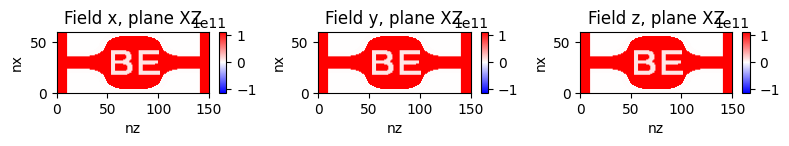

In [29]:
# Built-in method in `Field` class
# to inspect material tensors (ieps, imu, sigma)
# or EM fields E, H, J before simulating

solver.ieps.inspect(plane='XZ', cmap='bwr')

### 🕒 Time-Stepping Routine

Wakis uses the **Leapfrog scheme**, a second-order accurate and explicit time integrator. This method updates the magnetic and electric fields in a staggered fashion:

$$
\begin{align}
\mathbf{h}^{n+1} &= \mathbf{h}^n - \Delta t \, \widetilde{\mathbf{D}}_s \, \mathbf{M}_\mu^{-1} \, \mathbf{D}_A^{-1} \, \mathbf{C} \, \mathbf{e}^{n+0.5} \tag{3a} \\[6pt]
\mathbf{e}^{n+1.5} &= \mathbf{e}^{n+0.5} + \Delta t \, \mathbf{D}_s \, \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \widetilde{\mathbf{D}}_A^{-1} \, \widetilde{\mathbf{C}} \, \mathbf{h}^n 
- \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \mathbf{j}_{\text{src}}^n 
- \widetilde{\mathbf{M}}_\varepsilon^{-1} \, \widetilde{\mathbf{M}}_\sigma \, \mathbf{e}^{n+0.5} \tag{3b}
\end{align}
$$

### Running with custom time-loops
We could create a custom loop by adding a source and advancing the fields:

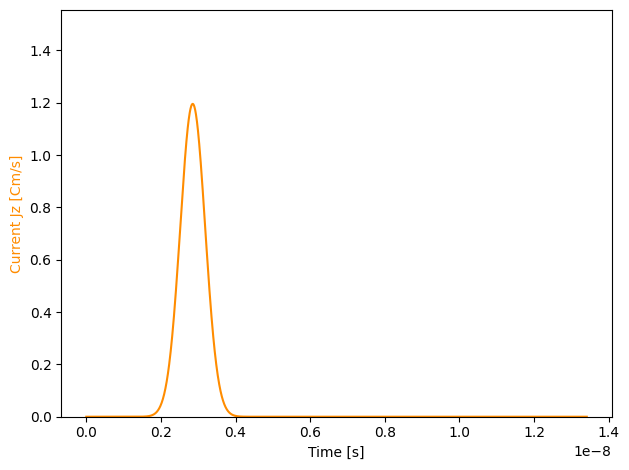

In [30]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]

from wakis.sources import Beam
beam = Beam(q=q, 
            sigmaz=sigmaz, 
            beta=beta,
            xsource=xs, 
            ysource=ys)
beam.plot(np.arange(0, 2000*solver.dt, solver.dt))

In [31]:
# Plotting settings

# List of 10 accessible and aesthetic colors selected by M. A. Petroff
from matplotlib.colors import LinearSegmentedColormap
petroff_colors = ["#3f90da", "#ffa90e", "#bd1f01","#94a4a2", "#832db6","#a96b59","#e76300", "#b9ac70","#717581","#92dadd",]
cmap = LinearSegmentedColormap.from_list(
    "petroff_bipolar", [petroff_colors[i] for i in (2, 6, 1, 3, 9, 0, 4)])

plotkw2D = {'title':'img/Ez_2d', 
            #'add_patch':['cavity'], 'patch_alpha':0,
            'patch_reverse' : True, 
            'vmin':-700, 'vmax':700,
            'interpolation' : 'gaussian',
            'cmap' : cmap,
            'plane': [slice(0, Nx), int(Ny/2), slice(0, Nz)]}

In [32]:
# Custom time-loop
solver.reset_fields()
Nt = 2000      
for n in tqdm(range(Nt)):

    beam.update(solver, n*solver.dt)
    solver.one_step()

    if n%20 == 0 and n>600:
       solver.plot2D('E', component='z', off_screen=True, n=n, **plotkw2D)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 95.96it/s]


In [33]:
# We can save the solver E, H, and J fields at that timestep to a HDF5 file
solver.save_state(f'state_n{n}.h5')

In [ ]:
!convert -delay 10 -loop 0 img/Ez_2d*.png BE_cavity.gif

![BEcavity](BE_cavity.gif "segment")

## Field visualization

Once the simulation is finished, plot the result in a 3D plot:
* Interpolating to the STL cavity
* Or simply cutting the simulation domain

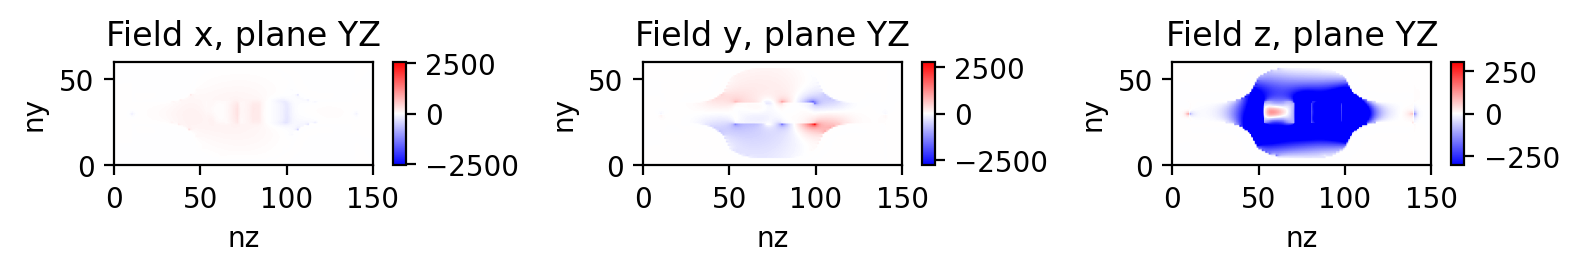

In [47]:
# Quick inspecting method
solver.E.inspect(plane='YZ', fig dpi=200)

In [39]:
# 3D interpolation onto cavity
solver.plot3DonSTL('E', component='Abs', cmap=cmap, clim=[0, 1000],
    stl_with_field='cavity', field_opacity=1.0,
    stl_transparent=['letters'], stl_opacity=0.8, stl_colors='white',
    clip_plane=True, clip_normal='-y', clip_origin=[0,0,0],
    off_screen=False, zoom=1.2, n=n, title='img/E_Abs_3d')

Widget(value='<iframe src="/proxy/41795/index.html?ui=P_0x7e18c93cb810_3&reconnect=auto" class="pyvista" style…

In [40]:
cmap = plt.get_cmap('Blues_r', 10)
solver.plot3D('E', component='Abs', cmap=cmap, clim=[10, 1000],
        add_stl='letters', stl_opacity=1.0, stl_colors='darkgreen',
        clip_interactive=True, clip_normal='-y',
        off_screen=False, zoom=1.0, n=n, title='img/Ez_3d')

Widget(value='<iframe src="/proxy/41795/index.html?ui=P_0x7e18c9459b10_4&reconnect=auto" class="pyvista" style…

We can also inspect the other components of the fields, e.g. the Electric field:

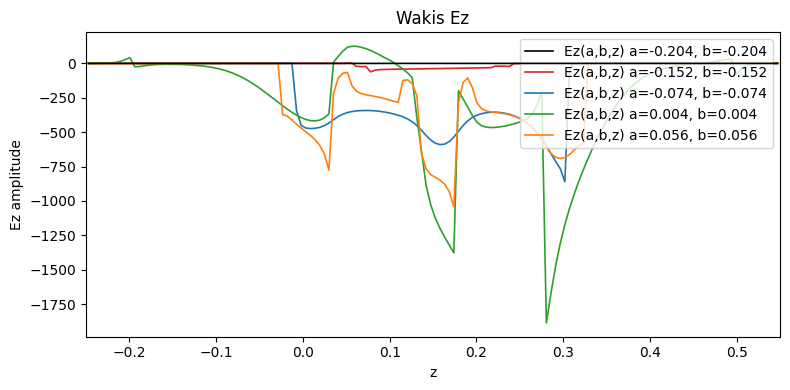

In [41]:
# %matplotlib ipympl
# Plot Electric field component in 2D using imshow
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.1, 0.2, 0.35, 0.5, 0.6], 
              xscale='linear', yscale='linear',
              off_screen=False, title='img/Ez1d')

Or reset all of them to zero:

In [48]:
solver.reset_fields()

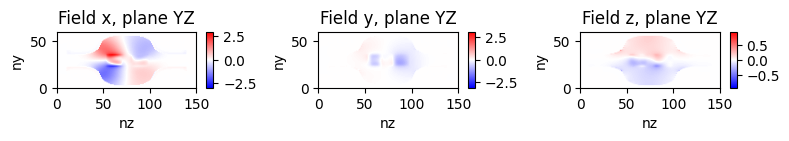

In [52]:
solver.H.inspect()

And then load the saved state:

In [50]:
solver.load_state(f'state_n{n}.h5')

### Running with a routine e.g. Wakefield solver

We need to setup our WakeSolve class with the desired beam parameters and wakelength.

#### 🔌 Source: Gaussian Beam Current $J_z$

A rigid Gaussian bunch current is modeled as a line distribution:

$$
\mathbf{J}_z(x_{\text{src}}, y_{\text{src}}, \vec{z}) = 
\frac{q \beta c}{\sqrt{2\pi} \sigma_z} \, 
\exp\left( -\frac{(\vec{s} - s_0)^2}{2\sigma_z^2} \right)
$$

with:
- $\vec{s} = \vec{z} - \beta c t$: beam-frame coordinate
- $s_0 = z_{\min} - \beta c t_{\text{inj}}$: center of bunch
- $q$ the charge in $\text{nC}$
- $\sigma_z$ the bunch length in $\text{m}$

This supports both **ultra-relativistic** ($\beta \approx 1$) and **low-beta** scenarios.

In [53]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> f_max = beta*c/3sigmaz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 30.  # [m]
skip_cells = 10   # no. cells
results_folder = f'001_results_wl{int(wakelength)}/'
wake = WakeSolver(q=q, 
                  sigmaz=sigmaz, 
                  beta=beta,
                  xsource=xs, ysource=ys, 
                  xtest=xt, ytest=yt,
                  skip_cells=skip_cells,           # Skip cells for wake potential integration at the boundary 
                  results_folder=results_folder,   
                  Ez_file=results_folder+'Ez.h5')

In [54]:
# ----------- Solver & Simulation ----------
# boundary conditions``
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

solver = SolverFIT3D(grid, wake,
                     bc_low=bc_low, bc_high=bc_high, 
                     bg='pec',      # backgorund material
                     use_stl=True,  # enable/disable geometry
                     use_mpi=False, # activate MPI
                     use_gpu=False, # activate GPU
                     )

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Using MKL backend for time-stepping...
Total solver initialization time: 0.28720784187316895 s


In [55]:
# Wakefield Solver run
solver.wakesolve(wakelength=wakelength)

Running electromagnetic time-domain simulation...


100%|████████████████████████████████████████████████████████████████████████████| 15733/15733 [02:04<00:00, 126.58it/s]


Reading h5 file 001_results_wl30/Ez.h5
Calculating longitudinal wake potential WP(s)


100%|████████████████████████████████████████████████████████████████████████| 138051/138051 [00:10<00:00, 13461.68it/s]


Calculating transverse wake potential WPx, WPy...


100%|███████████████████████████████████████████████████████████████████████| 138051/138051 [00:00<00:00, 466615.14it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


### 📈 Wake Potential and Impedance from 3D electromganetic simulations

Once the 3D E;ectromagnetic is done, Wakis will compute the wake potential and the impedance from the simulated fields:



* It will take care of saving the fields for the wake potential and impedance calculations:
  
The **wake potential**, expressed in $\text{V/pC}$, is calculated by integrating the electric and magnetic fields seen by a test particle as it follows behind the source:

$$
W(s) = \frac{1}{q_s} \int_{-\infty}^{\infty} \left[ E_z(z, t) + \beta c \, \vec{e}_z \times \vec{B}(z, t) \right]_{t = (s + z)/c} \, dz
$$

For ultra-relativistic beams, the transverse component vanishes, and the expression simplifies to:

$$
W_\parallel(s) = \frac{1}{q_s} \int_{-\infty}^{\infty} E_z(z, t = (s + z)/c) \, dz
$$

The **transverse wake potential** is recovered via the **Panofsky-Wenzel theorem**:

$$
W_{\perp,\alpha}(s) = \frac{\partial}{\partial \alpha} \int_{-\infty}^{s} W_\parallel(s') \, ds', \quad \alpha = x, y
$$

Wakis implements this gradient using second-order finite differences.

#### From Wake to Impedance

Given the bunch profile $\lambda(s)$ and the wake potential $W(s)$, the beam coupling impedance is computed in Fourier space ia a deconvolution:

- **Longitudinal impedance** in $\Omega$:

$$
Z_\parallel(\omega) = \beta c \cdot \frac{\mathcal{F}[W_\parallel(s)]}{\mathcal{F}[\lambda(s)]}
$$

- **Transverse impedance** in $\Omega/m$:

$$
Z_\perp(\omega) = -i \beta c \cdot \frac{\mathcal{F}[W_\perp(s)]}{\mathcal{F}[\lambda(s)]}
$$

where $\mathcal{F}$ denotes the Fourier transform. Wakis uses `numpy.fft` and zero-padding for smooth frequency analysis.

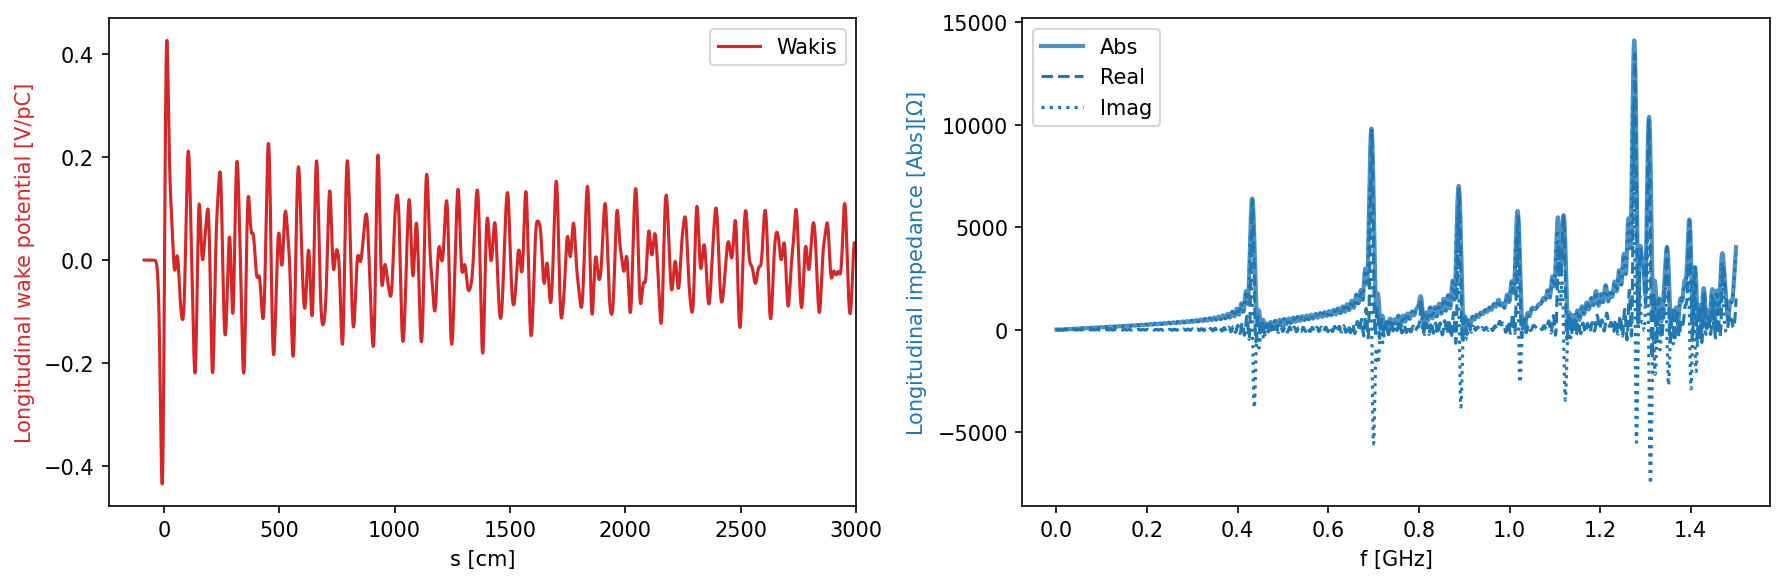

In [61]:
# Plot longitudinal wake potential and impedance
fig1, ax = plt.subplots(1,2, figsize=[10,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WP, c='tab:red', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()
fig1.savefig(results_folder+'longitudinal.png')
#plt.show()

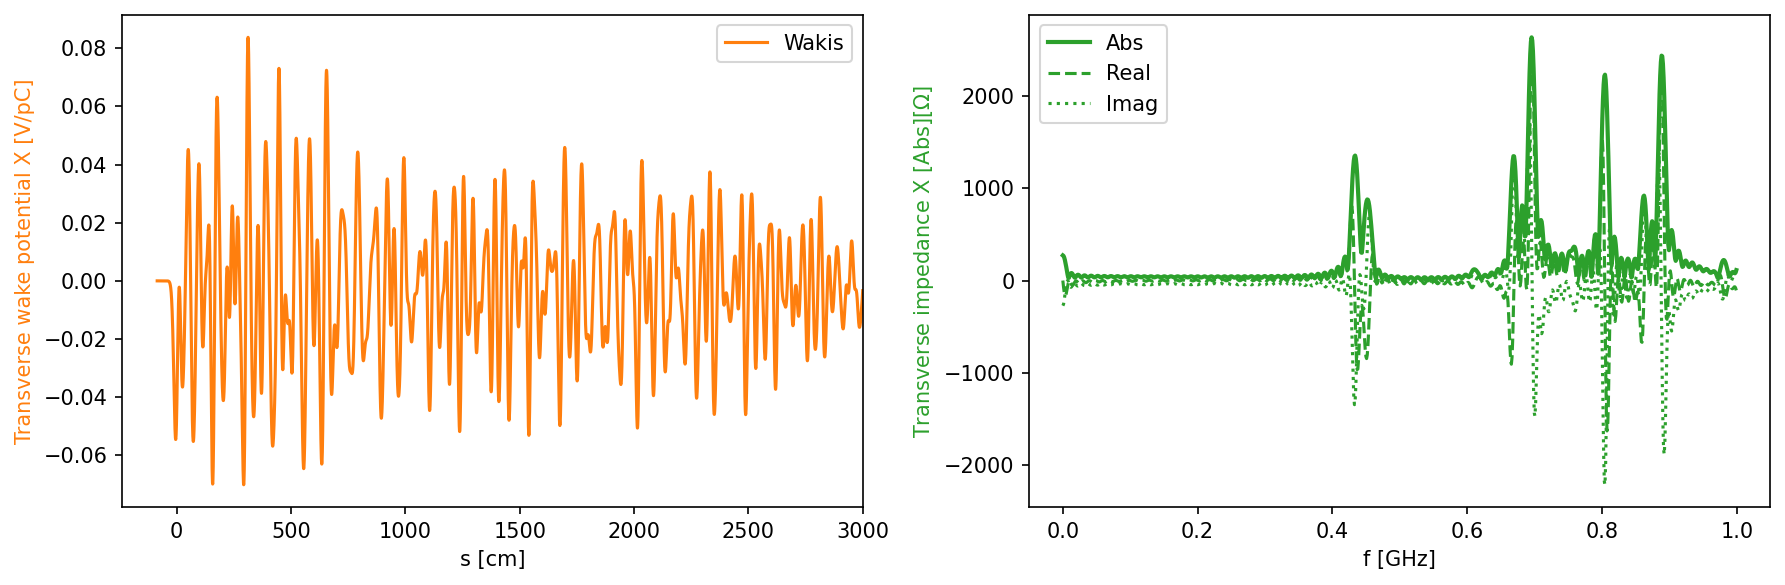

In [57]:
# Plot transverse x wake potential and impedance
fig2, ax = plt.subplots(1,2, figsize=[10,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPx, c='tab:orange', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential X [V/pC]', color='tab:orange')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.fx*1e-9, np.abs(wake.Zx), c='tab:green', lw=2, label='Abs')
ax[1].plot(wake.fx*1e-9, np.real(wake.Zx), c='tab:green', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.fx*1e-9, np.imag(wake.Zx), c='tab:green', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance X [Abs][$\Omega$]', color='tab:green')
ax[1].legend()

fig2.tight_layout()
fig2.savefig(results_folder+'transverse_x.png')
#plt.show()

NameError: name 'wakelength' is not defined

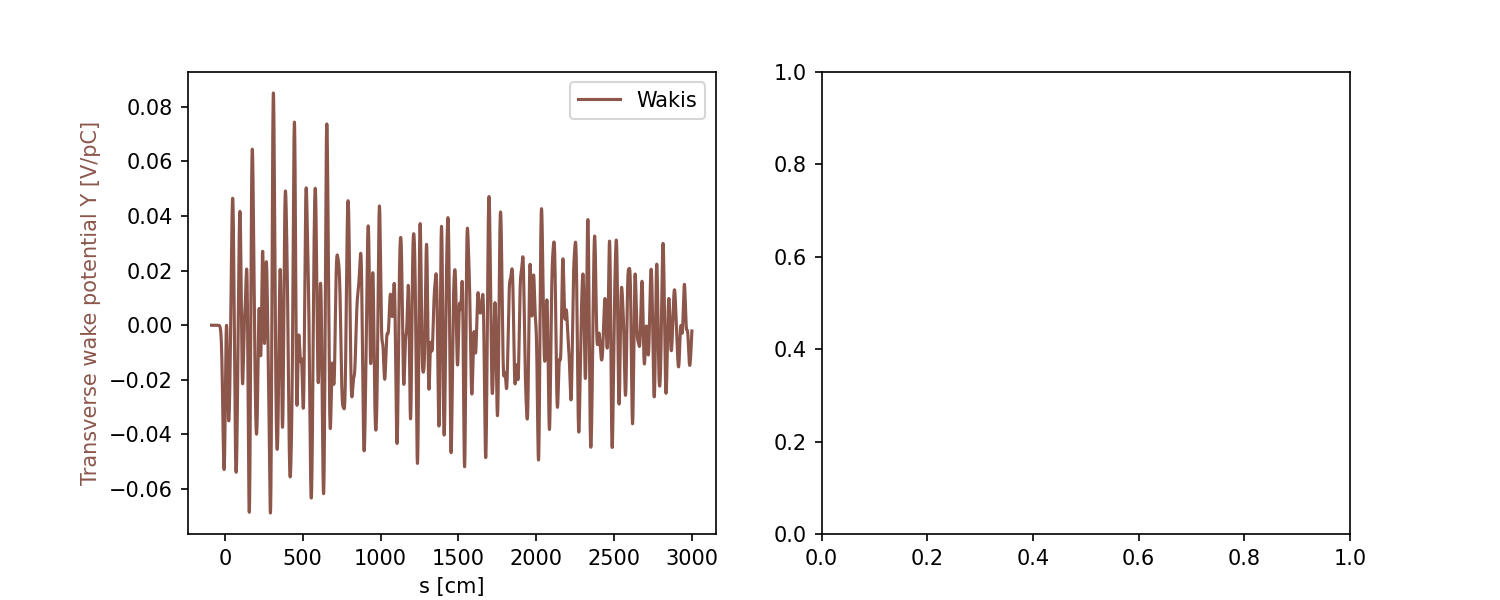

In [28]:
# Plot transverse y wake potential and impedance
fig3, ax = plt.subplots(1,2, figsize=[10,4], dpi=150)
ax[0].plot(wake.s*1e2, wake.WPy, c='tab:brown', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Transverse wake potential Y [V/pC]', color='tab:brown')
ax[0].legend()
ax[0].set_xlim(xmax=wakelength*1e2)

ax[1].plot(wake.fy*1e-9, np.abs(wake.Zy), c='tab:pink', lw=2, label='Abs')
ax[1].plot(wake.fy*1e-9, np.real(wake.Zy), c='tab:pink', ls='--', lw=1.5, label='Real')
ax[1].plot(wake.fy*1e-9, np.imag(wake.Zy), c='tab:pink', ls=':', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Transverse impedance Y [Abs][$\Omega$]', color='tab:pink')
ax[1].legend()

fig3.tight_layout()
fig3.savefig(results_folder+'transverse_y.png')
#plt.show()

In [59]:
# We can also recompute the quantities with different parameters e.g.:

wake.skip_cells = 15
wake.solve()                                    # recomputes all the quantities
wake.calc_long_Z(samples=10001, fmax=1.5e9)     # recomputes single quantities

Calculating longitudinal wake potential WP(s)


100%|████████████████████████████████████████████████████████████████████████| 138051/138051 [00:09<00:00, 14364.24it/s]


Calculating transverse wake potential WPx, WPy...


100%|███████████████████████████████████████████████████████████████████████| 138051/138051 [00:00<00:00, 467148.58it/s]


Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...
Calculating longitudinal impedance Z...


## Extrapolating the partially decayed simulation w/ `IDDEFIX`

The [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) (Impedance Determination through Differential Evolution FItting and eXtrapolation) python package will take the partially decayed wake and give back the fully decayed wake using the **Resonator formalism** and **Diferential Evolution's** algorithms powered with `scipy` and `pymoo`

With IDDEFIX, we can find the main resonators and use Evolutionary Algorithms to fit them to the partially decayed formalism:

In [1]:
import iddefix
from wakis import WakeSolver
from scipy.constants import c

In [17]:
# We can load previous results
sigmaz = 10e-2 
wake = WakeSolver(results_folder='001_results_wl30/')
wake.load_results()

In [12]:
# We can recompute the impedance with less samples to increase the EA speed
wake.calc_long_Z(samples=1001, fmax=1.2e9)

Calculating longitudinal impedance Z...


/home/edelafue/miniforge3/envs/wakis-mkl/lib/python3.11/site-packages/iddefix/smartBoundDetermination.py:183: RuntimeWarning: divide by zero encountered in scalar divide
  initial_Qs[i] = frequency_data[peak]/(upper_lower_bound*2)


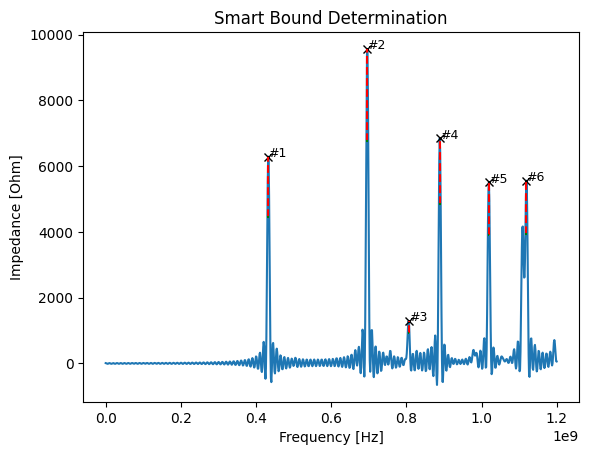


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |  5034.05 to 62925.64   | 45.00 to 450.00  |  4.22e+08 to 4.42e+08   
    2     |  7653.55 to 95669.36   | 72.37 to 723.75  |  6.85e+08 to 7.05e+08   
    3     |  1036.43 to 12955.41   |167.75 to 1677.50 |  7.96e+08 to 8.16e+08   
    4     |  5477.63 to 68470.37   | 92.50 to 925.00  |  8.79e+08 to 8.99e+08   
    5     |  4407.71 to 55096.37   |212.25 to 2122.50 |  1.01e+09 to 1.03e+09   
    6     |  4447.30 to 55591.26   |116.50 to 1165.00 |  1.11e+09 to 1.13e+09   
--------------------------------------------------------------------------------


In [13]:
# get bounds for the Differential Evolution fitting
bounds = wake.get_SmartBounds(freq_data=wake.f, impedance_data=wake.Z,
                        minimum_peak_height=800, distance=20, inspect_bounds=True,
                        Rs_bounds=[0.8, 10], Q_bounds=[0.5, 5], fres_bounds=[-0.01e9, +0.01e9]
                        )

In [19]:
DE_model = wake.get_DEmodel_fitting(freq_data=wake.f, impedance_data=wake.Z, 
                                    plane='longitudinal', dim='z', 
                                    parameterBounds=bounds.parameterBounds, 
                                    N_resonators=bounds.N_resonators, 
                                    DE_kernel='CMAES', 
                                    maxiter=1e5, cmaes_sigma=0.01, popsize=150, tol=1e-3,
                                    use_minimization=True, 
                                    minimization_margin=[0.3, 0.2, 0.01])

Fitting the impedance using Differential Evolution...
[!] Using the partially decayed resonator formalism for impedance
18
Starting point: [3.39798443e+04 2.47500000e+02 4.32248589e+08 5.16614570e+04
 3.98062500e+02 6.95199814e+08 6.99592017e+03 9.22625000e+02
 8.05663342e+08 3.69739973e+04 5.08750000e+02 8.88510989e+08
 2.97520405e+04 1.16737500e+03 1.01938626e+09 3.00192788e+04
 6.40750000e+02 1.11904357e+09]
n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |        1 |  1.573109E+09 |  1.573109E+09 |  0.0100000000 |  0.01000 |  0.01000 |  1.00005
     2 |      151 |  1.583106E+09 |  1.369888E+09 |  0.0137331451 |  0.01310 |  0.01462 |  1.28787
     3 |      301 |  1.513752E+09 |  1.295246E+09 |  0.0208316836 |  0.01973 |  0.02198 |  1.42083
     4 |      451 |  1.435154E+09 |  1.093153E+09 |  0.0334003562 |  0.03028 |  0.03771 |  1.59933
     5 |      601 |  1.308331E+09 |  8.044779E+08 |  0.0585754902 |  0.05191 |  0.06794 | 

### Plot the extrapolation result

In [20]:
# retrieve the wake potential, function and impedance analytically using the resonator formalism
from scipy.constants import c as c_light

new_wakelength = 100 # [m]
s, wake_potential = wake.get_extrapolated_wake(wakelength=new_wakelength, sigma=sigmaz/c_light, use_minimization=True)
t, wake_function = wake.get_extrapolated_wake_function(wakelength=new_wakelength, use_minimization=True)
f, impedance = wake.get_extrapolated_impedance(wakelength=new_wakelength, use_minimization=True)

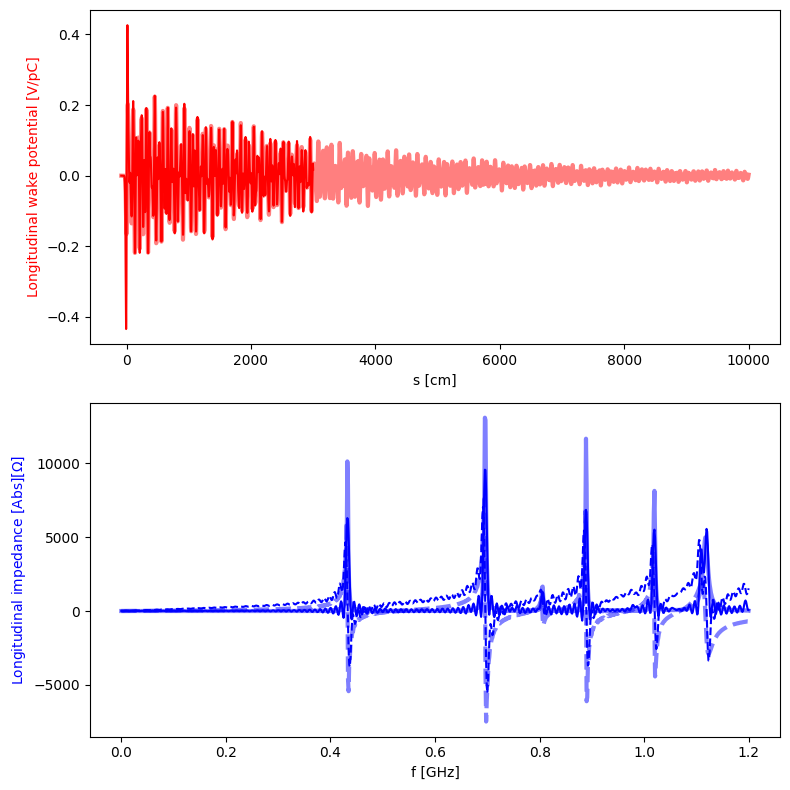

In [23]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(2,1, figsize=[8,8], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].plot(s*1e2, wake_potential, c='r', lw=3, alpha=0.5, label='Wakis DE extrapolation')
#ax[0].plot(t*c_light*1e2, wake_function/c_light, c='grey', lw=1.5, alpha=0.5, label='Wakis DE extrapolation')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Wakis - Re')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', lw=1.5, ls='--', label='Wakis - Imag')

ax[1].plot(f*1e-9, np.real(impedance), c='b', lw=3, alpha=0.5, label='Wakis DE - Re')
ax[1].plot(f*1e-9, np.imag(impedance), c='b', lw=3, ls='--', alpha=0.5, label='Wakis DE - Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

### Additionally, we can assess the fitting by the DE

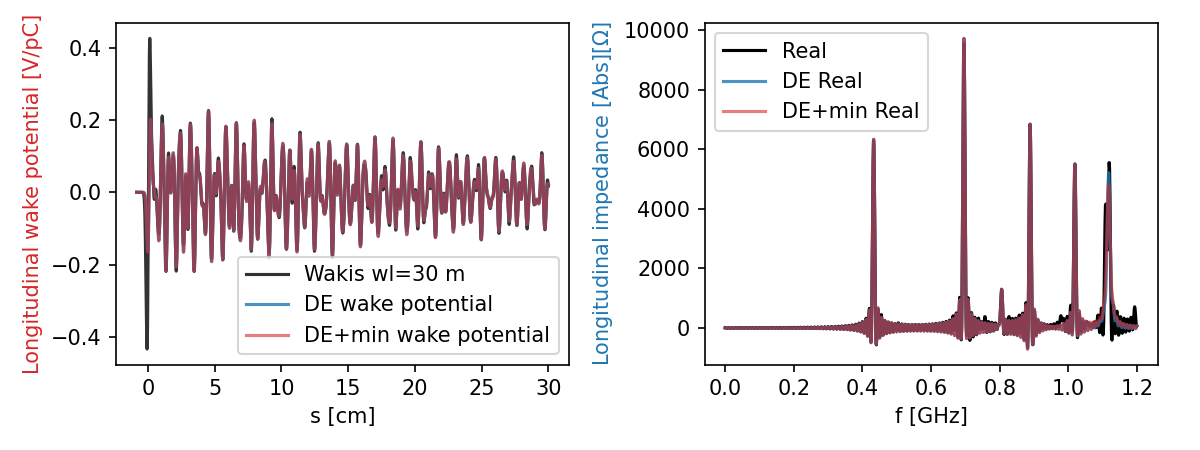

In [27]:
%matplotlib ipympl

# Retrieve partially decayed wake potential
WP_pd = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c, use_minimization=False)
WP_pd_min = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c)

# Retrieve partially decayed impedance
f_pd = np.linspace(0, 1.2e9, 10000)
Z_pd = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=False)
Z_pd_min = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=True)

fig1, ax = plt.subplots(1,2, figsize=[8,3], dpi=150)

ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8, label='Wakis wl=30 m')
ax[0].plot(wake.s, -WP_pd*1e-12, c='tab:blue', alpha=0.8, lw=1.5, label='DE wake potential')
ax[0].plot(wake.s, -WP_pd_min*1e-12, c='tab:red', alpha=0.6, lw=1.5, label='DE+min wake potential')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='-', c='k', lw=1.5, label='Real')
#ax[1].plot(f*1e-9, np.imag(Z), ls=':', c='k', lw=1.5, label='Imag')
#ax[1].plot(f*1e-9, np.real(Z_pd), c='tab:blue', label='Abs')
ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='-', c='tab:blue', alpha=0.8, lw=1.5, label='DE Real')
#ax[1].plot(f_pd*1e-9, np.imag(Z_pd), ls=':', c='tab:blue', alpha=0.6, lw=1.5, label='DE Imag')
ax[1].plot(f_pd*1e-9, np.real(Z_pd_min), ls='-', c='tab:red', alpha=0.6, lw=1.5, label='DE+min Real')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

### Extra: 🌡️ computing the beam-induced heating with BIHC

Let's imagine our BE cavity is installed in the LHC and we need to estimate if the **power loss** due to impedance is high enough that it can melt or damage the component

First we define the beam filling scheme and build our beam:

In [29]:
import bihc

In [31]:
# Create beam object
from bihc.fillingschemes import fillingSchemeLHC
fillingScheme = fillingSchemeLHC(ninj=9, ntrains=4, nbunches=72)
bl = 1.2e-9                 # bunch length [s]
Np = 2.3e11                 # bunch intensity [protons/bunch]
bunchShape = 'q-GAUSSIAN'   # bunch profile shape in time 
qvalue = 3/5                # value of q parameter in the q-gaussian distribution
fillMode = 'FLATTOP'        # Energy
fmax = 2e9                  # Maximum frequency of the beam spectrum [Hz]

beam = bihc.Beam(Np=Np, bunchLength=bl, fillingScheme=fillingScheme,
                bunchShape=bunchShape, qvalue=qvalue, 
                machine='LHC', fillMode=fillMode, spectrum='numeric', fmax=fmax)

print(f'* Number of bunches used: {np.sum(fillingScheme)}')
print(f'* Total intensity: {np.sum(fillingScheme)*Np:.2e} protons')

Setting custom beam from filling scheme
Elaborating Data...
* Number of bunches used: 2592
* Total intensity: 5.96e+14 protons


(0.0, 2.0)

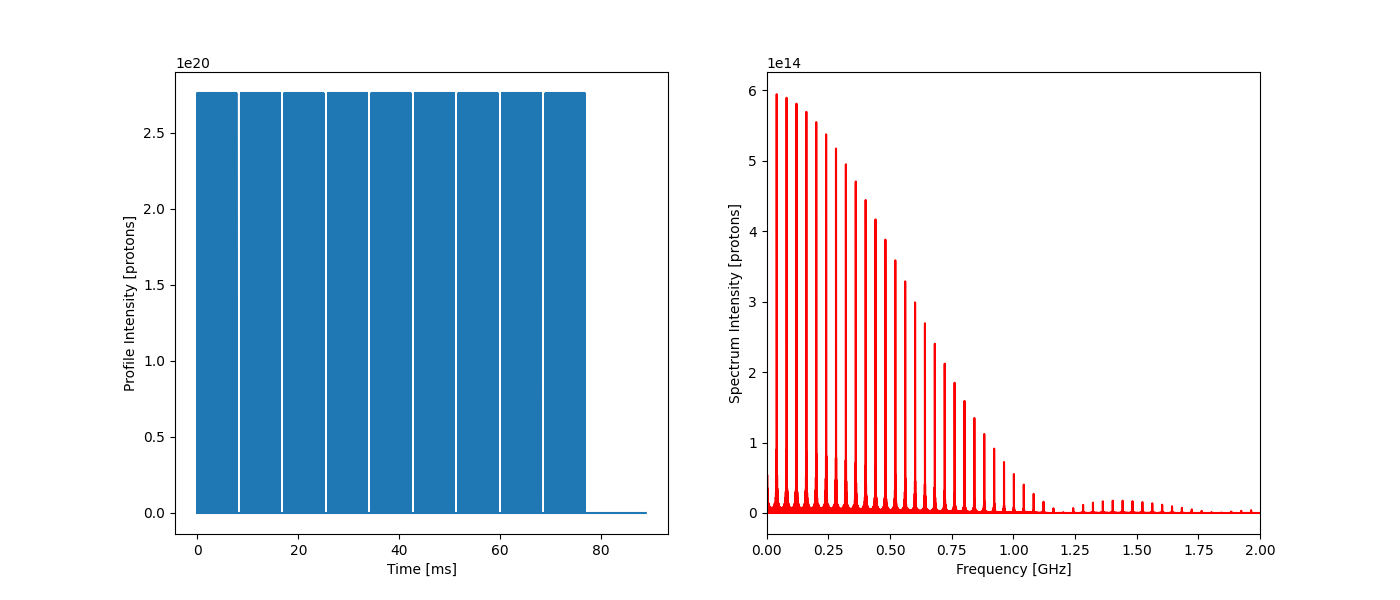

In [36]:
fig, ax = plt.subplots(1,2, figsize=[14,6])

t, prof = beam.longitudinalProfile
ax[0].plot(t*1e6, prof*beam.Np,)
ax[0].set_xlabel('Time [ms]')
ax[0].set_ylabel('Profile Intensity [protons]')

f, spectrum = beam.spectrum
ax[1].plot(f*1e-9, spectrum*beam.Np*np.sum(fillingScheme), c='r')
ax[1].set_xlabel('Frequency [GHz]')
ax[1].set_ylabel('Spectrum Intensity [protons]')
ax[1].set_xlim((0, 2.0))

### Impedance and spectrum
The beam induced heating depends on the interaction of the beam power spectrum and the beam-coupling impedance:

$$
P_{loss} = 2 (f_0 eN_{beam})^2 \cdot \sum_{p=0}^{+\infty} |\Lambda(p\omega_0)|^2 Re[Z_z(p \omega_0)]
$$

To assess it visually we can plot them together:


In [38]:
# We create an impedance object with BIHC:

# Partially decayed impedance from simulation
# wake = WakeSolver(results_folder='001_results_wl30/')
# wake.load_results()

# Or fully decayed impedance from extrapolation
f, impedance = wake.get_extrapolated_impedance(wakelength=new_wakelength, use_minimization=True)
Z = bihc.Impedance(f=f, Z=impedance)

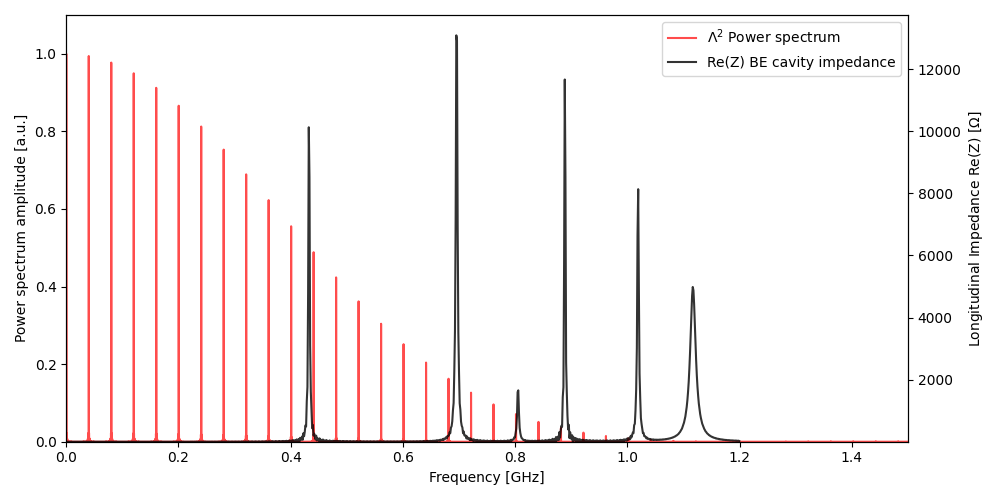

In [40]:
# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
#ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=0, ymax=1.1)

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
axx.set_ylim(ymin=1e-0) 
#axx.set_yscale('log')

axx.legend([l0, l1], [f'$\Lambda^2$ Power spectrum', 'Re(Z) BE cavity impedance'], loc=0)

fig.tight_layout()

### Calculate Beam-Induced power loss
With `BIHC` we can simply calculate the power loss by `beam.getPloss(Z)`. 

However, due to inacuracies in the wakefield simulation or the CAD model, or to account for changes in the revolution frequency during operation, `BIHC` also performs a **statistical analysis** by rigidly shifting the impedance curve `beam.getShiftedPloss(Z, shift=shift)` to account for different overlaps with the beam spectral lines:

In [41]:
print('Calculate beam-induced heating of CAP-cavity impedance')
print('----------------------------------------------------')
# Get unshifted ploss 
ploss, ploss_density = beam.getPloss(Z) 
print(f'Dissipated power (no-shift): {ploss:.3} W')

# Get min/max power loss with rigid shift
shift = 20e6  # distance between shift steps [Hz]
shifts, power = beam.getShiftedPloss(Z, shift=shift)

print(f'Minimum dissipated power: P_min = {np.min(power):.3} W, at step {shifts[np.argmin(power)]}')
print(f'Maximum dissipated power: P_max = {np.max(power):.3} W, at step {shifts[np.argmax(power)]}')
print(f'Average dissipated power: P_mean = {np.mean(power):.3} W')

Calculate beam-induced heating of CAP-cavity impedance
----------------------------------------------------
Dissipated power (no-shift): 7.49e+02 W


Computing scan: 100%|██████████████████████████████████████████████████████████████| 3556/3556 [00:05<00:00, 624.75it/s]

Minimum dissipated power: P_min = 7.07e+02 W, at step 1514
Maximum dissipated power: P_max = 1.51e+04 W, at step 766
Average dissipated power: P_mean = 3.02e+03 W


We can now retrieve and plot the impedance curve that gives the maximum power loss. We can observe that when the peak at lower frequency is shifted and placed exactly on top of the beam spectral line, the power loss dramatically increases

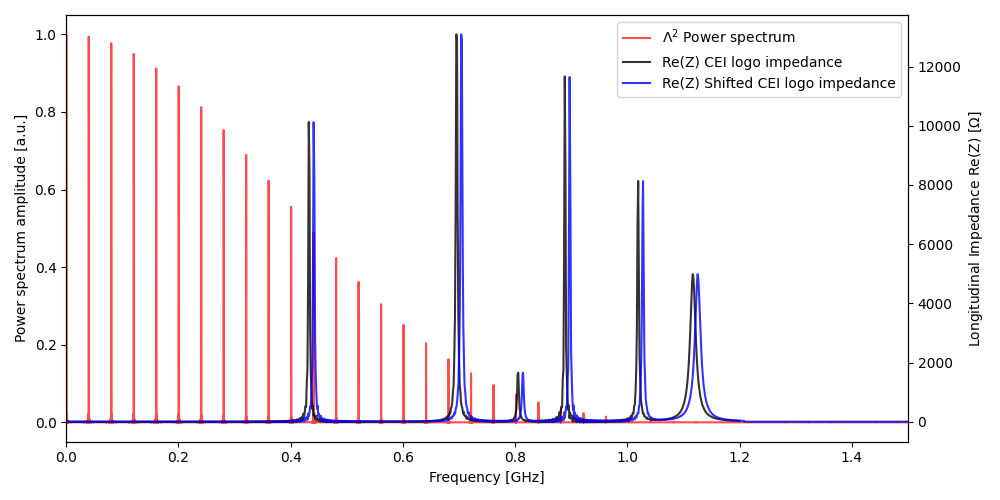

In [42]:
# Get unshifted ploss max
Z_max = beam.Zmax

# Plot impedance and spectrum 
fig, ax = plt.subplots(figsize=[10,5])
axx = ax.twinx()

l0, = ax.plot(beam.powerSpectrum[0]/1e9, beam.powerSpectrum[1], color='r', alpha=0.7)
l1, = axx.plot(Z.f/1e9, Z.Zr, color='k', alpha=0.8, ls='-')
l2, = axx.plot(Z_max.f/1e9, Z_max.Zr, color='b', alpha=0.8, ls='-')

ax.set_ylabel('Power spectrum amplitude [a.u.]', color='k')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
#ax.set_ylim(ymin=1e-3, ymax=1.1)
#ax.set_yscale('log')

axx.set_ylabel(r'Longitudinal Impedance Re(Z) [$\Omega$]', color='k')
#axx.set_ylim(ymin=1e-1, ymax=1e5) 
#axx.set_yscale('log')

axx.legend([l0, l1, l2], [f'$\Lambda^2$ Power spectrum', 'Re(Z) BE cavity impedance', 'Re(Z) Shifted BE cavity impedance'], loc=0)

fig.tight_layout()

We can also plot the power loss by frequency with the power loss density:

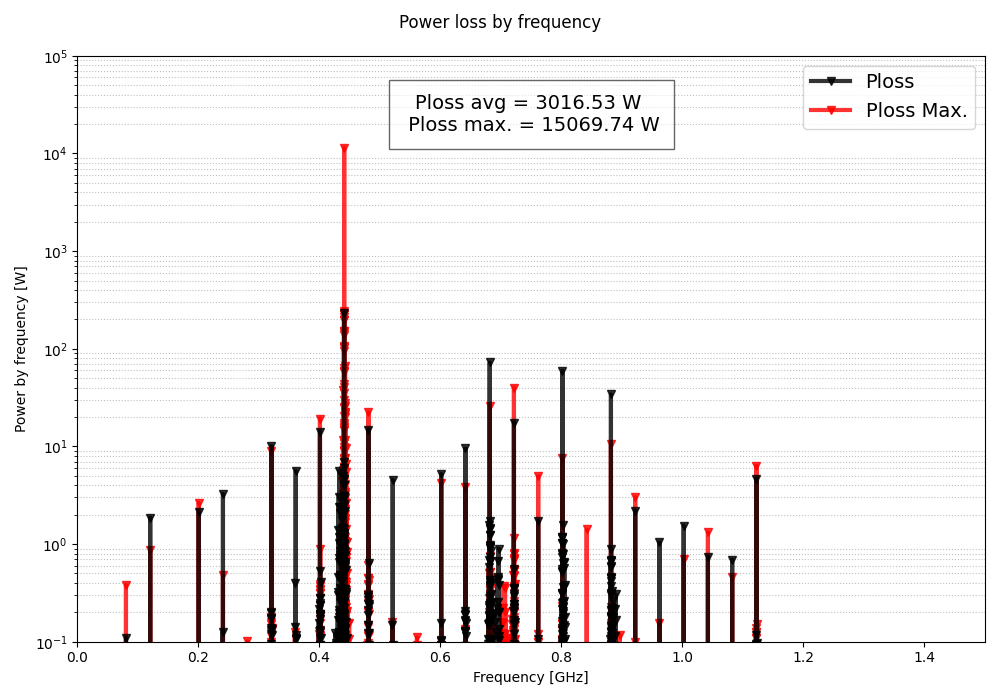

In [47]:
fig, ax = plt.subplots(figsize=[10,7])

# Unshifted impedance
ploss, ploss_density = beam.getPloss(Z) 
# Shifted impedance
ploss_max, ploss_density_max = beam.getPloss(Z_max) 

l1, = ax.plot(np.linspace(0, Z_max.f.max()/1e9, len(ploss_density_max )), ploss_density_max , color='r', marker='v', lw=3, alpha=0.8)
l0, = ax.plot(np.linspace(0, Z.f.max()/1e9, len(ploss_density )), ploss_density , color='k', marker='v', lw=3, alpha=0.8)

ax.set_ylabel('Power by frequency [W]', color='k')
ax.set_yscale('log')
ax.set_xlabel('Frequency [GHz]')
ax.set_xlim((0, 1.5))
ax.set_ylim(ymin=1e-1, ymax=1e5)
ax.grid(which='minor', axis='y', alpha=0.8, ls=':')

ax.legend([l0, l1, l2], [f'Ploss', 'Ploss Max.'], loc=1, fontsize=14)
ax.text(0.5, 0.9, f'Ploss avg = {round(np.mean(power ),2)} W \n Ploss max. = {round(np.max(power ),2)} W',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
        bbox ={'facecolor':'white','alpha':0.6, 'pad':10},
        color='k', fontsize=14)

fig.suptitle('Power loss by frequency')
fig.tight_layout()

If the BE cavity was placed in a common-beam chamber, it would see the effect of **2 beam power loss**:
$$
P_{loss}(s) = 
(2 f_0 e N_{beam})^2 \cdot \sum_{p=0}^{+\infty} |\Lambda(p\omega_0)|^2 \cdot (Re[Z^0_z(p \omega_0)] + \\
[\Delta y_1(s) + \Delta y_2(s)]Re[Z^1_z(p \omega_0)]) \cdot (1 - cos(p \omega_0 \tau_s))
$$

<br>



The beam-induced heating in this case is a function of the distance with the interaction point (IP) and can be greater than a factor 2 of the 1-beam case. 

We can compute this with `BIHC` too:

In [49]:
#       2 beam case
# ----------------------
# Defining the phase shift array for LHC
from scipy.constants import c
start = -3.5  #m from IP
stop = 3.5    #m from IP
resolution = 0.001 #m power2b
s = np.arange(start, stop, resolution)
tau_s = 2*s/c # Phase shift array [s]

power2b = beam.get2BeamPloss(Z, tau_s=tau_s)
power2b_max = beam.get2BeamPloss(Z_max, tau_s=tau_s)

Computing 2-beam power: 100%|██████████████████████████████████████████████████████| 7000/7000 [00:21<00:00, 322.05it/s]


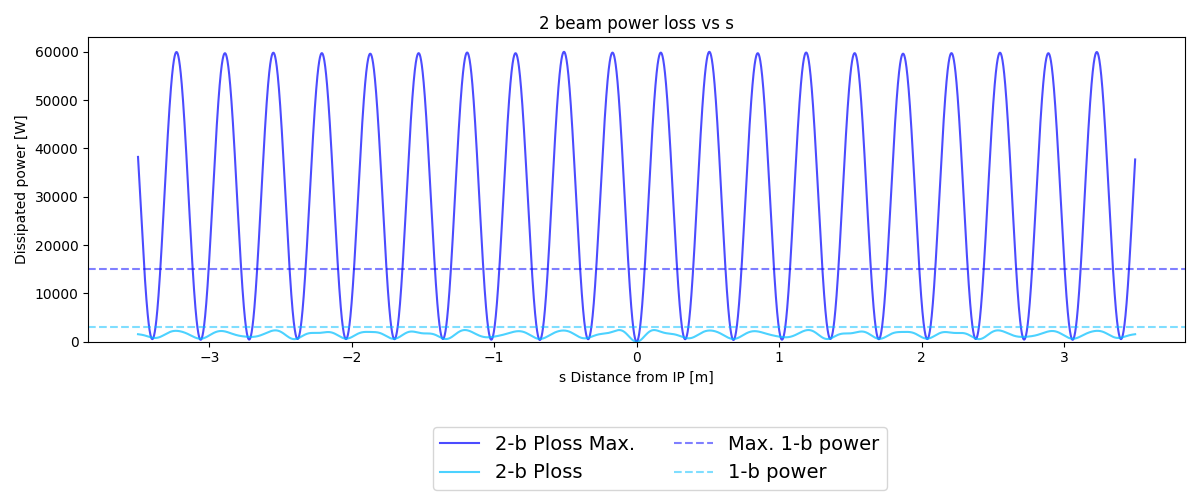

In [50]:
# Plot power los vs distance from IP, qgaussian
fig, ax = plt.subplots(figsize=[12,5])

ax.plot(s, power2b_max, label="2-b Ploss Max.", c='b', ls='-', alpha=0.7)
ax.plot(s, power2b, label="2-b Ploss ", c='deepskyblue', ls='-', alpha=0.7)

ax.set_ylabel('Dissipated power [W]')
ax.set_xlabel('s Distance from IP [m]')

ax.axhline(np.max(power), c='b', ls='--', alpha=0.5, label='Max. 1-b power')
ax.axhline(np.mean(power), c='deepskyblue', ls='--', alpha=0.5, label='1-b power')

ax.set_ylim(ymin=0)
ax.set_title(f'2 beam power loss vs s')
fig.legend(bbox_to_anchor=(0.55, 0.0), fontsize=14, loc='lower center', ncol=2)
fig.tight_layout(rect=[0, 0.2, 1, 1])